<a href="https://colab.research.google.com/github/GodHandOne/Deeplerning_Study/blob/Chapter_4/MovieReview_Classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分类和回归术语表

样本（sample）或输入（input）：进入模型的数据点。

预测（prediction）或输出（output）：模型的输出结果。

目标（target）：真实值。对于外部数据源，理想情况下模型应该能够预测出目标。

预测误差（prediction error）或损失值（loss value）：模型预测与目标之间的差距。

类别（class）：分类问题中可供选择的一组标签。举例来说，对猫狗图片进行分类时，“猫”和“狗”就是两个类别。

标签（label）：分类问题中类别标注的具体实例。如果1234号图片被标注为包含类别“狗”，那么“狗”就是1234号图片的标签。

真实值（ground-truth）或标注（annotation）：数据集的所有目标，通常由人工收集。

二分类（binary classification）：一项分类任务，每个输入样本都应被划分到两个互斥的类别中。

多分类（multiclass classification）：一项分类任务，每个输入样本都应被划分到两个以上的类别中，比如手写数字分类。

多标签分类（multilabel classification）：一项分类任务，每个输入样本都可以被分配多个标签。举个例子，一张图片中可能既有猫又有狗，那么应该同时被标注“猫”标签和“狗”标签。每张图片的标签个数通常是可变的。

标量回归（scalar regression）：目标是一个连续标量值的任务。预测房价就是一个很好的例子，不同的目标价格形成一个连续空间。

向量回归（vector regression）：目标是一组连续值（比如一个连续向量）的任务。如果对多个值（比如图像边界框的坐标）进行回归，那就是向量回归。

小批量（mini-batch）或批量（batch）：模型同时处理的一小部分样本（样本数通常在8和128之间）。样本数通常取2的幂，这样便于在GPU上分配内存。训练时，小批量用于计算一次梯度下降，以更新模型权重。

## 加载IMDB数据集

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=10000)
print(train_data)
print(train_labels)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

## 将评论解码为文本

In [ ]:
word_index=imdb.get_word_index()
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
decoded_review=" ".join(reverse_word_index.get(i-3,"?") for i in train_data[0])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## 准备数据
需要将列表转换为张量

①填充列表，使其长度相等，再将列表转换成形状为(samples, max_length)的整数张量，然后在模型第一层使用能处理这种整数张量的层

②对列表进行multi-hot编码，将其转换为由0和1组成的向量。举个例子，将序列[8, 5]转换成一个10 000维向量，只有索引8和5对应的元素是1，其余元素都是0。然后，模型第一层可以用Dense层，它能够处理浮点数向量数据。

用multi-hot编码对整数序列进行编码

In [ ]:
import numpy as np
def vectorize_sequences(sequences,dimension=10000):
  results=np.zeros((len(sequences),dimension)) #创建一个形状为len(sequences),dimension的零矩阵
  for i,sequence in enumerate(sequences):
    for j in sequence:
      results[i,j]=1.
  return results
x_train=vectorize_sequences(train_data) #向量化
x_test=vectorize_sequences(test_data) #向量化
print(x_train)
print(len(x_train))
y_train=np.asarray(train_labels).astype("float32")
y_test=np.asarray(train_labels).astype("float32")

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
25000


## 构建模型

当输入数据是向量，标签是标量时，可使用带有relu激活函数的密集连接层的简单堆叠

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model=keras.Sequential([
    layers.Dense(16,activation="relu"),
    layers.Dense(16,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])


## 编译模型
使用rmsprop优化器和binary_crossentropy损失函数配置模型

In [ ]:
from keras.mixed_precision.loss_scale_optimizer import optimizer
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=["accuracy"])

## 留出验证集

In [ ]:
x_val=x_train[:10000]
partial_x_train=x_train[10000:]
y_val=y_train[:10000]
partial_y_train=y_train[10000:]

##训练模型


In [ ]:
history=model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val,y_val))

Epoch 1/20
30/30 [==============================] - 4s 94ms/step - loss: 0.5176 - accuracy: 0.7741 - val_loss: 0.3842 - val_accuracy: 0.8712
Epoch 2/20
30/30 [==============================] - 1s 38ms/step - loss: 0.3128 - accuracy: 0.8956 - val_loss: 0.3498 - val_accuracy: 0.8540
Epoch 3/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2347 - accuracy: 0.9222 - val_loss: 0.2847 - val_accuracy: 0.8860
Epoch 4/20
30/30 [==============================] - 1s 39ms/step - loss: 0.1889 - accuracy: 0.9372 - val_loss: 0.3027 - val_accuracy: 0.8785
Epoch 5/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1607 - accuracy: 0.9487 - val_loss: 0.2796 - val_accuracy: 0.8873
Epoch 6/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1321 - accuracy: 0.9585 - val_loss: 0.2946 - val_accuracy: 0.8843
Epoch 7/20
30/30 [==============================] - 2s 52ms/step - loss: 0.1171 - accuracy: 0.9631 - val_loss: 0.3221 - val_accuracy: 0.8802
Epoch 8/20
30

## 绘制训练损失和验证损失

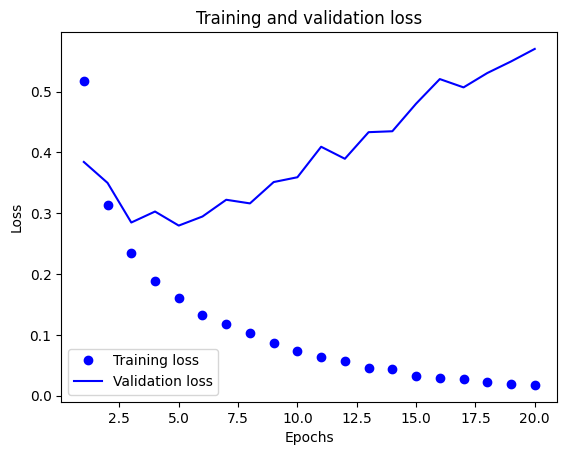

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")  #"bo"表示“蓝色圆点”
plt.plot(epochs, val_loss_values, "b", label="Validation loss")  #"b"表示“蓝色实线”
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 绘制训练精度和验证精度

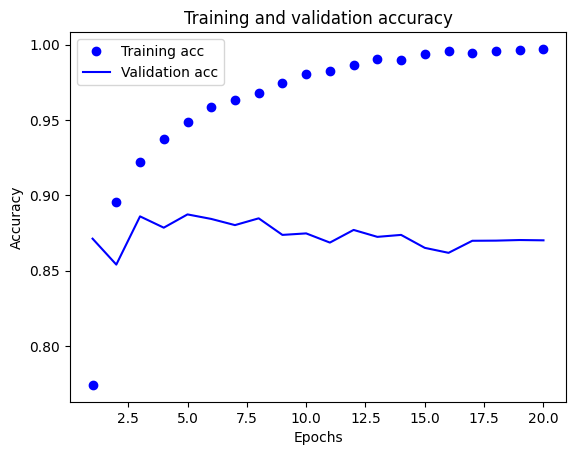

In [ ]:
plt.clf()  # 清空图像
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

##训练结果存在过拟合情况，重新训练一个模型

In [ ]:
import numpy as np
from tensorflow.keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=10000)
print(train_data)
print(train_labels)

word_index=imdb.get_word_index()
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
decoded_review=" ".join(reverse_word_index.get(i-3,"?") for i in train_data[0])
print(decoded_review)

def vectorize_sequences(sequences,dimension=10000):
  results=np.zeros((len(sequences),dimension)) #创建一个形状为len(sequences),dimension的零矩阵
  for i,sequence in enumerate(sequences):
    for j in sequence:
      results[i,j]=1.
  return results

x_train=vectorize_sequences(train_data) #向量化
x_test=vectorize_sequences(test_data) #向量化
print(x_train)
print(len(x_train))
y_train=np.asarray(train_labels).astype("float32")
y_test=np.asarray(test_labels).astype("float32")

x_val=x_train[:10000]
partial_x_train=x_train[10000:]
y_val=y_train[:10000]
partial_y_train=y_train[10000:]

model=keras.Sequential([
    layers.Dense(16,activation="relu"),
    layers.Dense(16,activation="relu"),
    layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(partial_x_train,partial_y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)
print(results)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

## 利用训练好的模型对数据进行预测

In [ ]:
model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


array([[0.35416132],
       [0.99901074],
       [0.95911616],
       ...,
       [0.11002175],
       [0.1768424 ],
       [0.65451294]], dtype=float32)

## 进一步实验，尝试新的表示层或者损失函数或者激活函数

In [ ]:
import numpy as np
from tensorflow.keras.datasets import imdb
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=10000)
print(train_data)
print(train_labels)

word_index=imdb.get_word_index()
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
decoded_review=" ".join(reverse_word_index.get(i-3,"?") for i in train_data[0])
print(decoded_review)

def vectorize_sequences(sequences,dimension=10000):
  results=np.zeros((len(sequences),dimension)) #创建一个形状为len(sequences),dimension的零矩阵
  for i,sequence in enumerate(sequences):
    for j in sequence:
      results[i,j]=1.
  return results

x_train=vectorize_sequences(train_data) #向量化
x_test=vectorize_sequences(test_data) #向量化
print(x_train)
print(len(x_train))
y_train=np.asarray(train_labels).astype("float32")
y_test=np.asarray(test_labels).astype("float32")

x_val=x_train[:10000]
partial_x_train=x_train[10000:]
y_val=y_train[:10000]
partial_y_train=y_train[10000:]

model=keras.Sequential([
    layers.Dense(32,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(16,activation="tanh"),
    layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer="rmsprop",loss="mse",metrics=["accuracy"])
model.fit(partial_x_train,partial_y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test,y_test)
print(results)

model.predict(x_test)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

array([[0.36902624],
       [0.98671687],
       [0.9843126 ],
       ...,
       [0.2664333 ],
       [0.16192289],
       [0.8286949 ]], dtype=float32)